# Relatório Parte 2

Grupo: Caio Victor do Amaral Cunha Sarmento, Claudio de Souza Brito, Gabriel Teixeira Patrício

## Introdução

### <div style="text-align: justify"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; O objetivo desta segunda parte do projeto é implementar um reconhecedor de padrões baseado em PPM ou LZW com a utilização de um banco de dados previamente rotulado. Como o algoritmo escolhido foi o LZW, inicialmente será gerado um dicionário para a etapa de treinamento para cada categoria do banco de dados selecionado, que no nosso caso, foi o ORL Database of Faces.<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Em seguida, o banco de dados será divido em amostras de treino e classificação utilizando a técnica de validação cruzada, ou seja, para cada categoria do banco de dados, ou cada pessoa em um total de 40 pessoas, foram selecionadas todas as amostras (10 para cada pessoa) -1 para treinamento (9 para treinamento) e 1 amostra para classificação, com a seleção de amostras sendo aleatória. Para classificação será utilizado o algoritmo dos K-Vizinhos mais Próximos (K-NN, k-nearest neighbors), com k=1, utilizando como métrica de distância o tamanho do arquivo comprimido. Como o algoritmo escolhido foi o LZW, métrica de distância escolhida foi a quantidade de índices utilizado pelo LZW. O treinamento consiste em gerar o dicionário de cada categoria do banco de dados. A classificação/testes consiste em comprimir 1 amostra (que não foi utilizada na geração do modelo) em todos os modelos/dicionários. Durante a compressão da amostra de teste o dicionário permanecerá estático e a amostra de teste será atribuída ao modelo que proporcionou a melhor compressão.
</div>

## Metodologia

### <div style="text-align: justify"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Utilizando o banco de dados de imagens ORL Database of Faces, como tratamento foi descartado o cabeçalho do arquivo e utilizada apenas a sequência de pixels. O código foi desenvolvido na linguagem de programação Python na versão 3.8.4 no ambiente Jupyter Notebook, com auxílio das bibliotecas numpy, scykit-learn, time, struct e matplotlib. O banco de treinamento e arquivo de teste foram escolhidos aleatoriamente com a utilização do numpy.random, com 9 arquivos para treino e 1 para classificação, no total de 10 arquivos por pessoa, em um total de 40 pessoas no banco de dados. Em relação aos valores de K, foram testados todos os valores no intervalo de K=9 ao K=16. Durante a classificação, o dicionário se manteve estático. As curvas de Taxa de acerto x K e de Tempo de Processamento x K serão apresentados ao final do relatório. Por fim, a métrica de distância utilizada foi a quantidade de índices do LZW, isto é, a amostras de teste será atribuída ao modelo com o menor número de índices (melhor compressão).
</div>

## Desenvolvimento

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; A seguir, temos o código do projeto com comentários nas funcionalidades mais importantes, explicando o que foi realizado em cada etapa, como pode ser visto abaixo:

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; A função treino recebe as imagens de treino e o valor do K atual, e retorna o dicionário modelo

In [1]:
import time
from tqdm import tqdm
import struct

def treino(train, k):
    dicionario = {}
    
    for i in range(2**8):
        dicionario[i.to_bytes(1, 'big')] = i
    
    newValue = 256
    new = ''
    old = ''
        
    for mensagem in train: # pra cada item de treinamento
        for letra in mensagem: # rodar compressão
            new = old + letra

            if new.encode('ISO-8859-1') not in dicionario: 
                if len(dicionario) < 2**k:
                    dicionario[new.encode('ISO-8859-1')] = newValue
                    newValue += 1
                else:
                    break

                old = letra
            else:
                old = new
        if len(dicionario) >= 2**k:
            break
        
    return dicionario

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; A função teste recebe a imagem de teste e o dicionário estático, e retorna o número de índices de compressão

In [2]:

def teste(mensagem, dicionario):
    comprimida = []
    new = ''
    old = ''

    for letra in mensagem:
        new = old + letra

        if new.encode('ISO-8859-1') not in dicionario: 
            
            numCod = dicionario[old.encode('ISO-8859-1')]

            comprimida.append(numCod)

            old = letra
        else:
            old = new

    numCod = dicionario[old.encode('ISO-8859-1')]
    comprimida.append(numCod)
    
    return len(comprimida)


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Essa é a função main, onde faremos todo o processamento, e chamaremos as outras funções

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

tempo = []
K = [9,10,11,12,13,14,15,16]
acertos = []

for k in range(9,17): # pra cada K
    start = time.time()
    
    testes = []
    dicionario = []
    numAcerto = 0
    
    for i in range(0,40): #pra cada pessoa
        imagem = []

        for j in range(0, 10): #pra cada foto da pessoa
            arquivo = open("orl_faces/s" + str(i+1) + "/" + str(j+1) + ".pgm", "rb").read()[14:]
            arquivo = arquivo.decode('ISO-8859-1')
            imagem.append(arquivo)
            
        train, test = train_test_split(imagem, test_size=0.1, random_state=np.random) #divisao de treino e teste
        testes.append(test[0])  #colhendo os arquivos de teste
        
        dicionario.append(treino(train, k)) #colhendo os dicionarios
    for i in range(len(testes)): #para cada teste
        menor = 10000000

        for j in range(len(dicionario)): #para cada dicionario
            tam = teste(testes[i], dicionario[j]) #tamanho de indices do teste com o dicionario 

            if(tam < menor):
                menor = tam
                indice = j
        if(i == indice):
            numAcerto += 1

    print("K = " +str(k)+ ", acertos: "+str(numAcerto))
    acertos.append(numAcerto)
    
    end = time.time()
    tempo.append(end-start)
    

K = 9, acertos: 10
K = 10, acertos: 4
K = 11, acertos: 11
K = 12, acertos: 11
K = 13, acertos: 19
K = 14, acertos: 33
K = 15, acertos: 36
K = 16, acertos: 38


## Resultados

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Como pode ser observado, acima são mostrados via print a quantidade de acertos para cada valor de K, no qual a melhor taxa de acertos obtida foi para o K valendo 16, podendo ser confirmado ao analisar o gráfico abaixo de Acertos x K. Já em relação ao tempo de processamento, o K valendo 16 também foi o que apresentou maior tempo, podendo ser visualizado no gráfico abaixo de Tempo x K:  


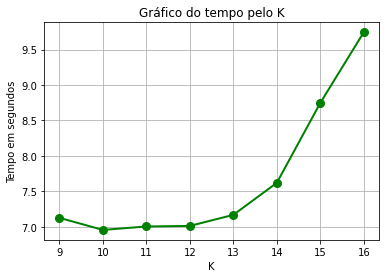

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig, bx = plt.subplots()

bx.plot(K, tempo, 'go-', linewidth=2, markersize=8)
bx.xaxis.set_major_locator(ticker.MultipleLocator(1))
bx.set(xlabel='K', ylabel='Tempo em segundos', title='Gráfico do tempo pelo K')
bx.grid()

plt.show()


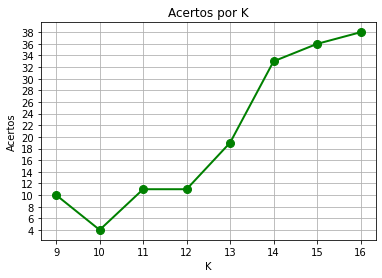

In [14]:
import matplotlib.ticker as plticker
fig, bx = plt.subplots()

bx.plot(K, acertos, 'go-', linewidth=2, markersize=8)
bx.yaxis.set_major_locator(plticker.MultipleLocator(base=2.0))
bx.set(xlabel='K', ylabel='Acertos', title='Acertos por K')
bx.grid()

plt.show()
